<a href="https://colab.research.google.com/github/shibukawar/learning-deep-learning/blob/master/notebook/rnn_name_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [6]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2022-06-22 06:10:16--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.91.2, 99.86.91.29, 99.86.91.5, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.91.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  5.89MB/s    in 0.5s    

2022-06-22 06:10:17 (5.89 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  

In [7]:
from io import open
import glob
import os

In [8]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt']


In [9]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [10]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

# 5文字なので長さ5のテンソル
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
len(string.ascii_letters), string.ascii_letters

(52, 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')

In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # input to hidden layer
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # input to output layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [14]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8795, -2.8640, -3.0188, -2.8363, -3.0032, -2.9213, -2.9074, -2.8335,
         -2.7908, -2.8117, -2.9085, -2.8103, -2.9141, -2.9011, -2.9508, -2.8611,
         -2.9100, -2.9380]], grad_fn=<LogSoftmaxBackward0>)


In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 8)


In [16]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Takahama
category = German / line = Wagner
category = Spanish / line = Etxeberria
category = English / line = Trickett
category = French / line = Sauvageon
category = Chinese / line = Lu
category = Czech / line = Hrula
category = Dutch / line = Agthoven
category = Italian / line = Arena
category = Irish / line = Kavanagh


In [17]:
criterion = nn.NLLLoss()

In [18]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    # 隠れ層の重み初期化
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [19]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.4991 Huerta / Japanese ✗ (Spanish)
10000 10% (0m 14s) 1.0886 Suk / Korean ✓
15000 15% (0m 20s) 2.3451 Ronald / French ✗ (English)
20000 20% (0m 27s) 1.7559 Christie / Scottish ✓
25000 25% (0m 34s) 0.6548 Lozhchenko / Russian ✓
30000 30% (0m 41s) 1.3463 Faerber / German ✓
35000 35% (0m 48s) 0.8972 Porra / Spanish ✓
40000 40% (0m 55s) 4.3178 Torisei / Czech ✗ (Japanese)
45000 45% (1m 1s) 1.3454 Moreno / Italian ✗ (Spanish)
50000 50% (1m 8s) 0.2914 Travert / French ✓
55000 55% (1m 15s) 1.2372 Brown / Scottish ✓
60000 60% (1m 21s) 0.5073 Ruadhain / Irish ✓
65000 65% (1m 28s) 2.2237 Duan / Vietnamese ✗ (Chinese)
70000 70% (1m 35s) 2.6706 Kasai / Arabic ✗ (Japanese)
75000 75% (1m 42s) 1.9691 Rothwell / Scottish ✗ (English)
80000 80% (1m 49s) 0.3333 Kouros / Greek ✓
85000 85% (1m 56s) 0.3632 Asanuma / Japanese ✓
90000 90% (2m 3s) 0.9921 Kafka / Czech ✓
95000 95% (2m 9s) 1.6416 Campos / Greek ✗ (Portuguese)
100000 100% (2m 16s) 2.5792 Abascal / Czech ✗ (Spanish)


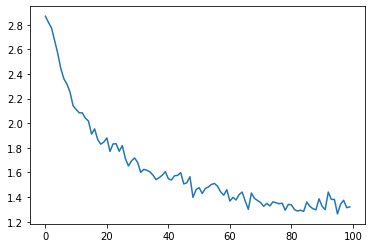

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

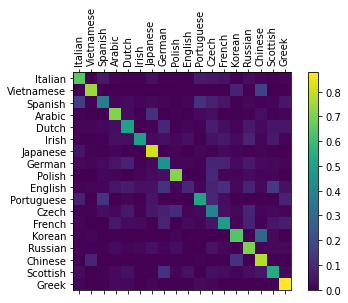

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [22]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Miyazaki')
predict('Shibukawa')


> Miyazaki
(-0.05) Japanese
(-3.08) Polish
(-5.61) Russian

> Shozawa
(-0.09) Japanese
(-2.99) Polish
(-4.03) Arabic

> Shibukawa
(-0.01) Japanese
(-6.43) Dutch
(-6.86) Czech
